In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [3]:
cad_df = pd.read_csv('final_data.csv')
cad_df['Cath'].value_counts()

Cath
0    216
1     87
Name: count, dtype: int64

# ***Forward Selection***

In [4]:
#Separate features and target columns
X_feature = cad_df.drop('Cath', axis=1)
y_target = cad_df['Cath']

rf_model = RandomForestClassifier(random_state=1)
forward_selector = SequentialFeatureSelector(estimator=rf_model, k_features=30, forward=True, floating=False,scoring='accuracy', cv=2)
select_fit = forward_selector.fit(X_feature, y_target)
selected_features = X_feature.columns[list(select_fit.k_feature_idx_)]
X_forward = X_feature[selected_features]

print('Selected features with Forward selection: ', selected_features)
print("\nDataframe with only the selected features:")
print(X_forward.head(5))

Selected features with Forward selection:  Index(['Age', 'Sex', 'BMI', 'DM', 'HTN', 'Current Smoker', 'FH', 'CRF',
       'Airway disease', 'Thyroid Disease', 'CHF', 'DLP', 'Edema',
       'Weak Peripheral Pulse', 'Typical Chest Pain', 'Dyspnea',
       'Function Class', 'Atypical', 'LowTH Ang', 'Q Wave', 'St Depression',
       'Tinversion', 'LVH', 'Poor R Progression', 'FBS', 'HDL', 'WBC', 'Lymph',
       'EF-TTE', 'Region RWMA'],
      dtype='object')

Dataframe with only the selected features:
   Age  Sex        BMI  DM  HTN  Current Smoker  FH  CRF  Airway disease  \
0   53    1  29.387755   0    1               1   0    0               0   
1   67    0  28.398718   0    1               0   0    0               0   
2   54    1  20.077335   0    0               1   0    0               0   
3   66    0  26.838648   0    1               0   0    0               0   
4   50    0  37.165193   0    1               0   0    0               0   

   Thyroid Disease  ...  St Depression  

# ***Data splitting***

In [5]:
#60% data for training, 20% data for validation, 20% data for testing
X_train, X_temp, y_train, y_temp = train_test_split(X_forward, y_target, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"The training set contains {X_train.shape[0]} patient records and {X_train.shape[1]} features.")
print(f"The validation set contains {X_val.shape[0]} patient records with the same {X_val.shape[1]} features.")
print(f"The test set also holds {X_test.shape[0]} patient records, each with {X_test.shape[1]} features.")

The training set contains 181 patient records and 30 features.
The validation set contains 61 patient records with the same 30 features.
The test set also holds 61 patient records, each with 30 features.


# ***SMOTENC***

In [6]:
categorical_cols = [col for col in X_train.columns if X_train[col].nunique() <= 4]
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=1)
X_balanced, y_balanced = smote_nc.fit_resample(X_train, y_train)

print("Imbalanced distribution:", Counter(y_train))
print("Balanced distribution:", Counter(y_balanced))

Imbalanced distribution: Counter({0: 133, 1: 48})
Balanced distribution: Counter({1: 133, 0: 133})


Applied SMOTENC balancing only to the testing set

In [7]:
X_balanced

Age  Sex        BMI  DM  HTN  Current Smoker  FH  CRF  Airway disease  \
0     53    1  34.086605   0    0               1   0    0               0   
1     53    1  27.681661   0    1               1   0    0               0   
2     80    0  23.283419   0    1               0   0    0               0   
3     55    1  28.401111   0    0               0   1    0               0   
4     68    0  26.666667   1    1               0   0    0               1   
..   ...  ...        ...  ..  ...             ...  ..  ...             ...   
261   55    0  28.208440   0    0               0   0    0               0   
262   65    0  27.323015   0    0               0   0    0               0   
263   54    0  28.265720   0    1               0   0    0               0   
264   41    0  25.145340   0    1               0   0    0               0   
265   60    0  32.200240   0    1               0   0    0               0   

     Thyroid Disease  ...  St Depression  Tinversion  LVH  Poor R Progression  \
0                  0  ...              0           0    0                   0   
1                  0  ...              0           1    0                   0   
2                  0  ...              1           0    0                   0   
3                  1  ...              0           1    0                   0   
4                  0  ...              0           0    0                   1   
..               ...  ...            ...         ...  ...                 ...   
261                0  ...              0           0    0                   0   
262                0  ...              0           0    0                   0   
263                0  ...              0           1    0                   0   
264                0  ...              0           0    0                   0   
265                0  ...              0           0    0                   0   

     FBS        HDL    WBC  Lymph  EF-TTE  Region RWMA  
0    108  37.000000   4700     40      55            0  
1    123  31.000000   6800     21      40            1  
2     94  39.000000  12400     40      40            4  
3     94  36.000000   6800     29      45            0  
4    360  30.000000   8600     28      55            0  
..   ...        ...    ...    ...     ...          ...  
261  105  42.683068   6300     29      52            0  
262   97  40.631876   5500     32      45            0  
263   92  50.509920   5324     41      54            0  
264   81  68.599183   5555     37      52            0  
265  106  39.372148   6382     36      52            0  

[266 rows x 30 columns]

# ***Random Forest Classifier (RF)***

In [8]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [2, 4, 8],
                'max_features': ['sqrt', 'log2']}

RF_mdl = RandomForestClassifier()
RF_randomcv = RandomizedSearchCV(RF_mdl, param_random, n_iter=20, cv=5)
RF_randomcv.fit(X_balanced, y_balanced)
RF_param = RF_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(RF_randomcv.best_score_))
print("Optimal parameters of RF classifier: ", RF_param)

#Training RF model with optimal parameters
RF_best_mdl = RandomForestClassifier(**RF_param)
RF_best_mdl.fit(X_balanced, y_balanced)
training_acc = RF_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of RF classifier: {training_acc:.4f}")

Best cross-validation score: 0.92
Optimal parameters of RF classifier:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 4}
Training phase accuracy of RF classifier: 0.9398


*Predicting on the validation and testing data*

In [9]:
val_pred = RF_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = RF_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.68      0.79      0.73        19

    accuracy                           0.82        61
   macro avg       0.79      0.81      0.80        61
weighted avg       0.83      0.82      0.82        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.94      0.80      0.87        41
           1       0.69      0.90      0.78        20

    accuracy                           0.84        61
   macro avg       0.82      0.85      0.83        61
weighted avg       0.86      0.84      0.84        61



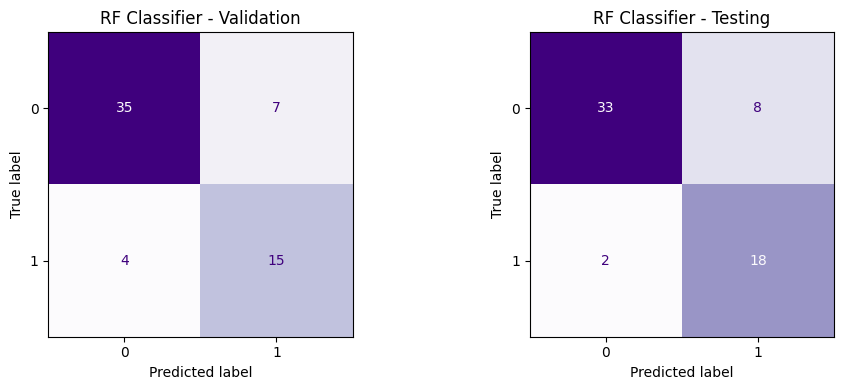

In [10]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plotting the validation confusion matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('RF Classifier - Validation')

# Plotting the testing confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('RF Classifier - Testing')

plt.tight_layout()
plt.show()

# ***XGBoost (XGB)***

In [11]:
param_random = {'n_estimators': [50, 80, 100],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.01, 0.02, 0.05],
                'subsample': [0.6, 0.7, 0.8]}

XGB_mdl = XGBClassifier()
XGB_randomcv = RandomizedSearchCV(XGB_mdl, param_random, n_iter=20, cv=5)
XGB_randomcv.fit(X_balanced, y_balanced)
XGB_param = XGB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(XGB_randomcv.best_score_))
print("Optimal parameters of XGB classifier: ", XGB_param)

#Training XGB model with optimal parameters
XGB_best_mdl = XGBClassifier(**XGB_param)
XGB_best_mdl.fit(X_balanced, y_balanced)
training_acc = XGB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of XGB classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of XGB classifier:  {'subsample': 0.6, 'n_estimators': 80, 'max_depth': 4, 'learning_rate': 0.05}
Training phase accuracy of XGB classifier: 0.9774


*Predicting on the validation and testing data*

In [12]:
val_pred = XGB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = XGB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.68      0.79      0.73        19

    accuracy                           0.82        61
   macro avg       0.79      0.81      0.80        61
weighted avg       0.83      0.82      0.82        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.78      0.90      0.84        20

    accuracy                           0.89        61
   macro avg       0.86      0.89      0.87        61
weighted avg       0.89      0.89      0.89        61



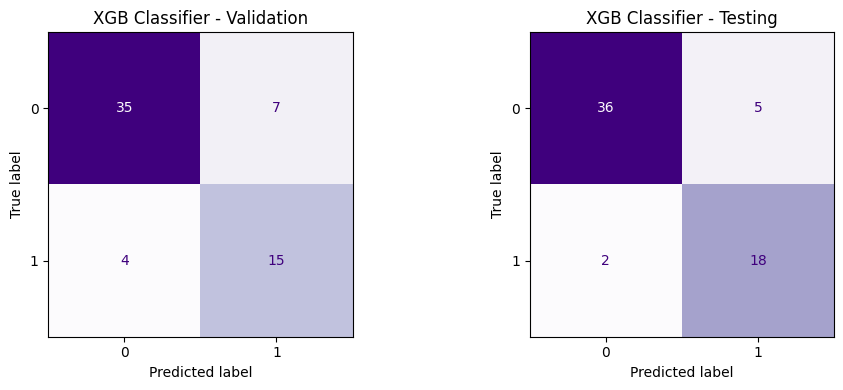

In [13]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('XGB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('XGB Classifier - Testing')

plt.tight_layout()
plt.show()

# ***Gradient Boosting (GB)***

In [14]:
param_random = {'n_estimators': [50, 100, 150],
                'max_depth': [2, 3, 4],
                'learning_rate': [0.005, 0.001, 0.015],
                'subsample': [0.6, 0.7, 0.8],
                'min_samples_split': [10, 12],
                'min_samples_leaf': [6, 8, 10]}

GB_mdl = GradientBoostingClassifier()
GB_randomcv = RandomizedSearchCV(GB_mdl, param_random, n_iter=20, cv=5)
GB_randomcv.fit(X_balanced, y_balanced)
GB_param = GB_randomcv.best_params_
print("Best cross-validation score: {:.2f}".format(GB_randomcv.best_score_))
print("Optimal parameters of GB classifier: ", GB_param)

#Training GB model with optimal parameters
GB_best_mdl = GradientBoostingClassifier(**GB_param)
GB_best_mdl.fit(X_balanced, y_balanced)
training_acc = GB_best_mdl.score(X_balanced, y_balanced)
print(f"Training phase accuracy of GB classifier: {training_acc:.4f}")

Best cross-validation score: 0.91
Optimal parameters of GB classifier:  {'subsample': 0.7, 'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': 4, 'learning_rate': 0.015}
Training phase accuracy of GB classifier: 0.9699


*Predicting on the validation and testing data*

In [15]:
val_pred = GB_best_mdl.predict(X_val)
print("=== Validation Report ===")
print(classification_report(y_val, val_pred))

test_pred = GB_best_mdl.predict(X_test)
print("=== Testing Report ===")
print(classification_report(y_test, test_pred))

=== Validation Report ===
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        42
           1       0.68      0.79      0.73        19

    accuracy                           0.82        61
   macro avg       0.79      0.81      0.80        61
weighted avg       0.83      0.82      0.82        61

=== Testing Report ===
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        41
           1       0.72      0.90      0.80        20

    accuracy                           0.85        61
   macro avg       0.83      0.86      0.84        61
weighted avg       0.87      0.85      0.86        61



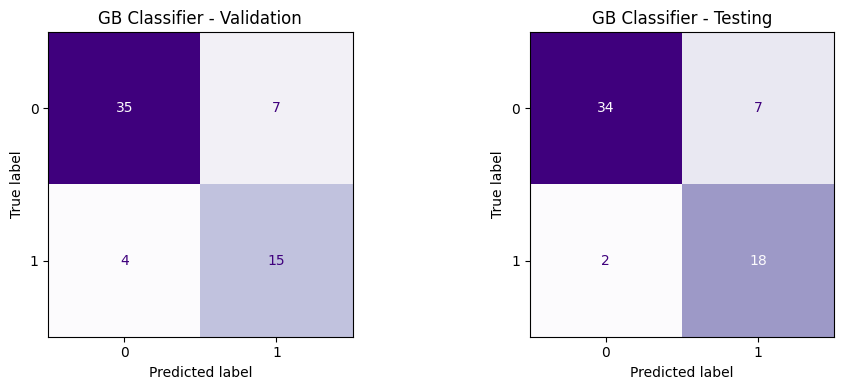

In [16]:
matrix_val = confusion_matrix(y_val, val_pred)
matrix_test = confusion_matrix(y_test, test_pred)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

disp_val = ConfusionMatrixDisplay(confusion_matrix=matrix_val, display_labels=[0, 1])
disp_val.plot(ax=axs[0], cmap='Purples', colorbar=False)
axs[0].set_title('GB Classifier - Validation')

disp_test = ConfusionMatrixDisplay(confusion_matrix=matrix_test, display_labels=[0, 1])
disp_test.plot(ax=axs[1], cmap='Purples', colorbar=False)
axs[1].set_title('GB Classifier - Testing')

plt.tight_layout()
plt.show()